<a href="https://colab.research.google.com/github/egshare/monai_handson/blob/master/segmentation_3d/Lesson01_ReadRTFiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PythonによるDICOM RTデータの読み込みと変換

本チュートリアルではDICOM-RTデータを用いた深層学習向けデータの一般的な前処理について説明します。DICOMの3D画像とDICOM RT Structureファイルの読み込み、3D再構成されたデータに対する画像処理および保存方法を学びます。

## 必要なパッケージのインストールとサンプルデータのダウンロード

In [ ]:
# 必要なライブラリをインストールする
# インストール後にカーネルを再起動して
!pip install -U SimpleITK  rt-utils==1.2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 92.1 MB/s eta 0:00:00


In [ ]:
# まずはDICOM RTのサンプルデータをダウンロードしてきましょう
# 本データはTCIA(Cancer Imaging Archive)で公開されているデータの一部である

!wget --no-clobber https://www.dropbox.com/s/8ghdfojohofsayv/RTDcmData.zip

--2023-09-04 12:49:40--  https://www.dropbox.com/s/8ghdfojohofsayv/RTDcmData.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8ghdfojohofsayv/RTDcmData.zip [following]
--2023-09-04 12:49:40--  https://www.dropbox.com/s/raw/8ghdfojohofsayv/RTDcmData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbfd3ba2f75ac2f7f303c747cad.dl.dropboxusercontent.com/cd/0/inline/CDGSs5Cyg5sHjt5CeVeqL5Ky20oMZgeqoCuNCCqZM6EoXecOBZfTYFJ4ljBfkmBV5hRYktHrZmHHFKdODAtqBwEPhSqbNBEMyJeEP0p8CbmI3KufeEqISNmNPXQX9TXC9to/file# [following]
--2023-09-04 12:49:40--  https://ucbfd3ba2f75ac2f7f303c747cad.dl.dropboxusercontent.com/cd/0/inline/CDGSs5Cyg5sHjt5CeVeqL5Ky20oMZgeqoCuNCCqZM6EoXecOBZfTYFJ4ljBfkmBV5hRYktHrZmHHFKdODAtqBwEPhSqbNBEMyJeEP0p8CbmI3KufeEqISN

In [ ]:
# ダウンロードしたファイルを解凍します
!unzip -n RTDcmData.zip

Archive:  RTDcmData.zip
   creating: RTDcmData/Prostate-AEC-001/
   creating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/
   creating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/1-1.dcm  
   creating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/1-001.dcm  
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/1-002.dcm  
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/1-003.dcm  
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/1-004.dcm  
  inflating: RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/1-005.dcm  
  inflating:

## PythonでDicom RTの読み込みを行い、データ変換処理をやってみましょう

In [ ]:
# 必要なライブラリをインポートする

import os, glob
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# DICOMディレクトリを読み込む
# スライス画像が保存されているフォルダパスを指定して、SimpleITKで読み込みを行う
rtImgDir = "RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578/"
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(rtImgDir)
reader.SetFileNames(dicom_names)

# SimpleITK Imageとして読み込む
image = reader.Execute()

In [ ]:
# numpy配列として3D画像を取得
img3D = sitk.GetArrayFromImage(image)
spacing = image.GetSpacing()
(spacingX, spacingY, spacingZ) = spacing
print(img3D.shape)  # (z, y, x)の順でサイズが表示される
print(spacing)  # 注意! (x, y, z)の淳でspacingが表示される

(179, 1024, 1024)
(0.454101562, 0.454101562, 2.0)


In [ ]:
# 簡単なピクセル値正規化例
min_ct_val, max_ct_val = -1000, 1000
img3DNorm = np.clip(img3D, min_ct_val, max_ct_val)  # 指定した範囲でクリップ
img3DNorm = ((img3DNorm - min_ct_val).astype("float")/ (max_ct_val - min_ct_val))  # 0-1.0に正規化

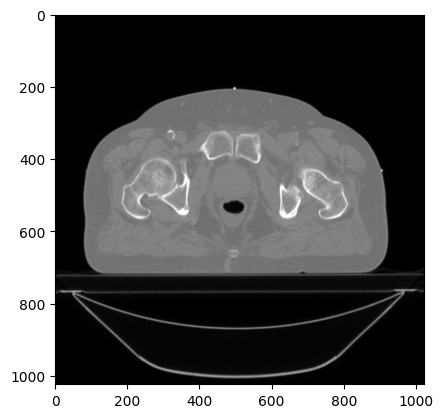

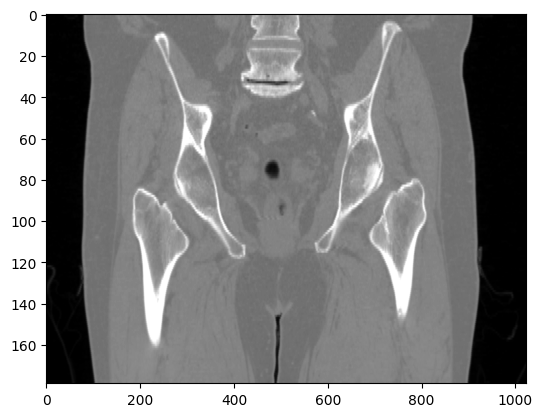

In [ ]:
# 真ん中のスライスを表示してみる
z = img3DNorm.shape[0] // 2
slice = img3DNorm[z]
plt.imshow(slice)
plt.gray()
plt.show()

# コロナル方向でもスライスを表示してみましょう
y = img3DNorm.shape[1] // 2
slice = img3DNorm[:, y]
# Image Position Patientに沿ってスライス方向がソートされるので、コロナル表示時はsliceの上下を反転して表示
# また、aspectを指定しなけr場、縦横1:1で表示されるので、画像が歪みます
plt.imshow(slice[::-1], aspect=spacingZ / spacingX)
plt.gray()
plt.show()

In [ ]:
# 残念ながら現時点においてSimpleITKではRT Structureデータを扱えないので、別のライブラリ(rt-utils)を用いる
from rt_utils import RTStructBuilder
from rt_utils.image_helper import *

In [ ]:
# rt-utilsで画像のDICOMが保存されているフォルダ、およびStructureファイルを指定して読み込む
rtStructPath = "./RTDcmData/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/1-1.dcm"
rtstruct = RTStructBuilder.create_from(
    dicom_series_path=rtImgDir,
    rt_struct_path=rtStructPath
)

In [ ]:
# 読み込まれたROI名の一覧を表示してみる
roiNames = rtstruct.get_roi_names()
print(roiNames)

['Bladder', 'Prostate', 'Femur_Head_L', 'Femur_Head_R', 'Rectum']


In [ ]:
# 1つ目のROIの3D配列を取得し、shapeと最小値、最大値を表示してみる
roi3D = rtstruct.get_roi_mask_by_name(roiNames[0]).astype("float")
print(roi3D.shape, roi3D.min(), roi3D.max())

(1024, 1024, 179) 0.0 1.0


In [ ]:
# SimpleITKと違い、rt_utilsから取得されるROIの3D配列の軸の並びが異なるので、SimpleITKに合うように軸を入れ替える
roi3D = np.transpose(roi3D, [2, 0, 1])

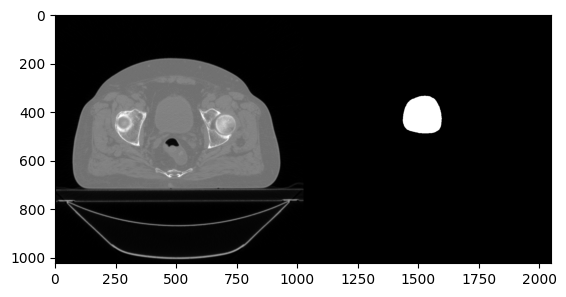

In [ ]:
# ROIが存在するスライスのZの範囲を調べる
z_indices, _, _ = np.where(roi3D)
z_min = z_indices.min()
z_max = z_indices.max()

# 画像スライスとROIのスライスを並べて表示してみよう
z = (z_min + z_max) // 2
slice = np.hstack((img3DNorm[z], roi3D[z]))
plt.imshow(slice)
plt.gray()
plt.show()

## nii形式として変換保存
nii形式はDICOM画像の3D情報のみに限定した保存形式で、MICCAI等の国際会議でもチャレンジ用データ形式として配布されています。

NVIDIA MONAIもこの形式の読み込みにデフォルトで対応していますので、読み込んだDICOM RT画像をこの形式に変換して保存しておくことで利便性が高まります

In [ ]:
# nii.gz形式書き出し用のパスを決定
outputDir = "output/"
os.makedirs(outputDir, exist_ok=True)
imgNiiPath = f"{outputDir}/img001.nii.gz"
roiNiiPath = f"{outputDir}/roi001.nii.gz"

In [ ]:
# nii.gz(niiの圧縮形式)で書き出す
image = sitk.GetImageFromArray(img3D)
image.SetSpacing(spacing)
sitk.WriteImage(image, imgNiiPath)
roi = sitk.GetImageFromArray(roi3D)
roi.SetSpacing(spacing)
sitk.WriteImage(roi, roiNiiPath)

(179, 1024, 1024) -1000 2976
(179, 1024, 1024) 0.0 1.0


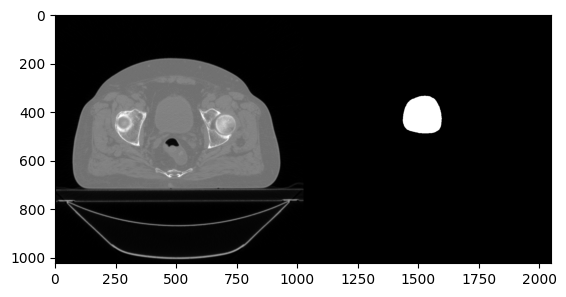

In [ ]:
# 書き出したnii.gz形式を読み込んで、同じデータが得られているかを確認しましょう

imgNii = sitk.ReadImage(imgNiiPath)
img3D = sitk.GetArrayFromImage(imgNii)
roiNii = sitk.ReadImage(roiNiiPath)
roi3D = sitk.GetArrayFromImage(roiNii)
print(img3D.shape, img3D.min(), img3D.max())
print(roi3D.shape, roi3D.min(), roi3D.max())

img3DNorm = np.clip(img3D, min_ct_val, max_ct_val)  # 指定した範囲でクリップ
img3DNorm = ((img3DNorm - min_ct_val).astype("float")/ (max_ct_val - min_ct_val))  # 0-1.0に正規化

slice = np.hstack((img3DNorm[z], roi3D[z]))
plt.imshow(slice)
plt.gray()
plt.show()

# 興味があれば下記も実行してみましょう


In [ ]:
# GoogleColoabで実行時にメモリ不足になる可能性があるので、不要なデータのメモリを開放しておく
import gc

image = None
roi = None
imgNii = None
roiNii = None

gc.collect()

3667

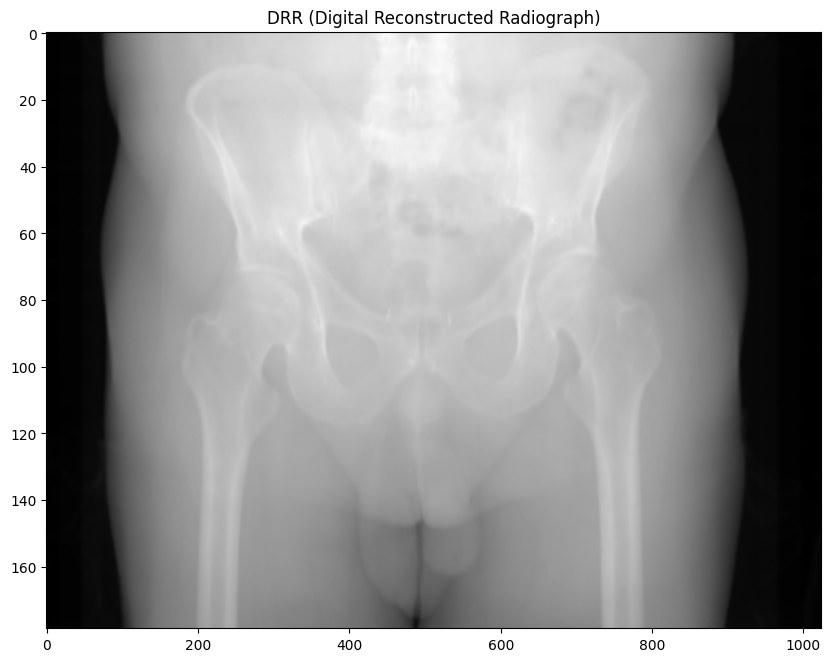

In [ ]:
# 擬似的な単純レントゲン(DRR)表示
# np.sumで軸を指定して値を合算して、2Dイメージを取得
# axisを0または2へ変更すると、アキシャル方向またはサジタル方向に変わります
axis = 1
aspect = spacingZ / spacingX
imgDRR = np.sum(img3D.astype("float"), axis=axis)
# 合算した画像全体を最大値と最小値で正規化

# 正規化して表示
vMin, vMax = imgDRR.min(), imgDRR.max()
imgDRR = (np.clip(imgDRR, vMin, vMax) - vMin) / (vMax - vMin)
figDRR = plt.figure(figsize = (10,10)) # create a large figure
axDRR = figDRR.add_subplot(111)
axDRR.imshow(imgDRR[::-1], interpolation='bilinear', aspect=aspect, cmap = "gray")
plt.title('DRR (Digital Reconstructed Radiograph)')
plt.show()

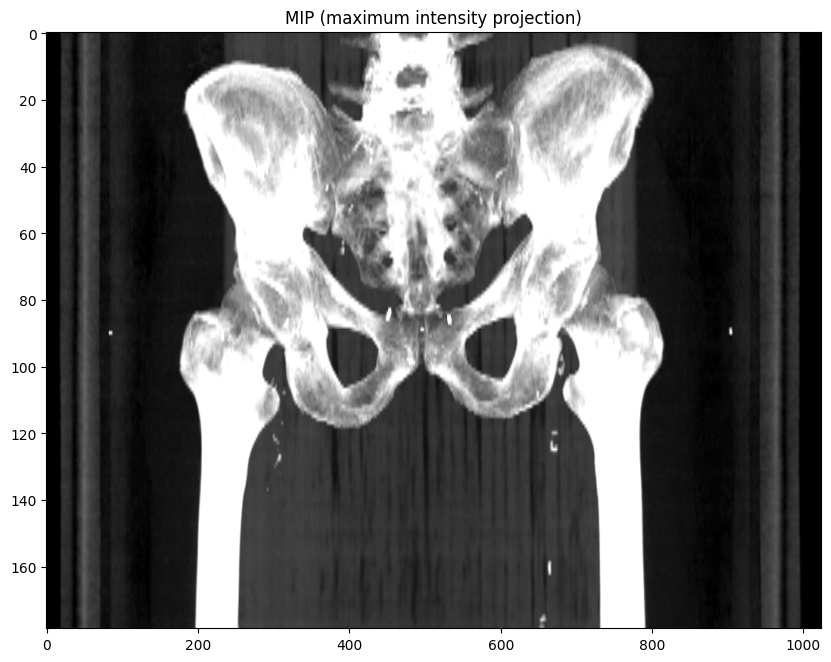

In [ ]:
# MIP(maximum intensityprojection：最大値投影法)表示
# 有効画素値範囲を決定して正規化
# wlとwwの値を変更すると画像の最大値が変わりますので、観測可能な対象が変わります
wl, ww = 500, 1000
vMin = wl - ww//2
vMax = vMin + ww
imgNorm = (np.clip(img3D, vMin, vMax) - vMin) / (vMax - vMin)

# np.sumで軸を指定して最大値を取得して、2Dイメージを取得
# axisを0または2へ変更すると、アキシャル方向またはサジタル方向に変わります
imgMIP = np.max(imgNorm.astype("float"), axis=axis)

# 正規化して表示
vMin, vMax = imgMIP.min(), imgMIP.max()
imgMIP = (np.clip(imgMIP, vMin, vMax) - vMin) / (vMax - vMin)
figDRR = plt.figure(figsize = (10,10)) # create a large figure
axDRR = figDRR.add_subplot(111)
axDRR.imshow(imgMIP[::-1], interpolation='bilinear', aspect=aspect, cmap = "gray")
plt.title('MIP (maximum intensity projection)')
plt.show()